## No-targeted Classifier Experiment

Hagámoslo sin target

In [1]:
%load_ext autoreload
%autoreload 2

import sklearn
import json


with open("../../data/dataset.json") as f:
    data = json.load(f)


## Exploratorio

In [2]:
def is_mixed(instance):
    return len(set(instance["labels"].values())) >= 2

len([x for x in data if is_mixed(x)]), len(data)

(160, 1930)

In [3]:

len([x for x in data if len(x["labels"]) > 1]), len(data)

(396, 1930)

In [4]:
import pandas as pd

label2id = {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
}

id2label = {v:k for k, v in label2id.items()}

def build_auxiliary_sentence(target):
    return f"¿Qué pensás de {target}?"

def build_df(data):
    return pd.DataFrame([{
        "id": x["id"],
        "sentence": x["titulo"],
        "target": target,
        "auxiliary_sentence": build_auxiliary_sentence(target),
        "label": label2id[label],
    } for x in data for (target, label) in x["labels"].items()])

Bien, está dentro de todo equilibrado

## Train test split

Lo hago sobre el dataset. No sería mejor hacerlo por oraciones?

In [5]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, random_state=2021, stratify=[len(x["labels"]) for x in data])

train_data, dev_data = train_test_split(train_data, random_state=2021, stratify=[len(x["labels"]) for x in train_data])

len(train_data), len(dev_data), len(test_data)

(1085, 362, 483)

## Armar dataset

In [6]:
from datasets import Dataset, Value, ClassLabel, Features

train_df = build_df(train_data)
dev_df = build_df(dev_data)
test_df = build_df(test_data)

features = Features({
    'sentence': Value('string'),
    'auxiliary_sentence': Value('string'),
    'label': ClassLabel(num_classes=3, names=["neg", "neu", "pos"])
})

columns = ["sentence", "auxiliary_sentence", "label"]

train_dataset = Dataset.from_pandas(train_df[columns], features=features)
dev_dataset = Dataset.from_pandas(dev_df[columns], features=features)
test_dataset = Dataset.from_pandas(test_df[columns], features=features)

In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = 'dccuchile/bert-base-spanish-wwm-uncased'

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, return_dict=True, num_labels=len(id2label)
)

model.config.id2label = id2label
model.config.label2id = label2id

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.model_max_length = 128


Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

In [8]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)

In [9]:
def tokenize(batch):
    """
    SIN TARGET
    """
    return tokenizer(batch['sentence'], padding='max_length', truncation=True)

batch_size = 16
eval_batch_size = 8

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=batch_size)
dev_dataset = dev_dataset.map(tokenize, batched=True, batch_size=eval_batch_size)
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=eval_batch_size)

(array([ 21., 122., 242., 407., 241., 197.,  76.,  19.,   5.,   6.]),
 array([ 7. , 10.6, 14.2, 17.8, 21.4, 25. , 28.6, 32.2, 35.8, 39.4, 43. ]),
 <BarContainer object of 10 artists>)

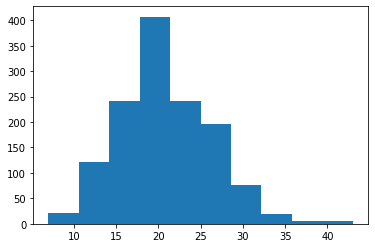

In [10]:
import matplotlib.pyplot as plt

lens = [sum(x["attention_mask"]) for x in train_dataset]


plt.hist(lens)

In [11]:
train_dataset[0].keys()

dict_keys(['attention_mask', 'auxiliary_sentence', 'input_ids', 'label', 'sentence', 'token_type_ids'])

In [12]:

def format_dataset(dataset):
    dataset = dataset.map(lambda x: {"labels": x["label"]})
    columns = ['input_ids', 'attention_mask', 'labels']
    if 'token_type_ids' in dataset.features:
        columns.append('token_type_ids')
    dataset.set_format(type='torch', columns=columns)
    return dataset

train_dataset = format_dataset(train_dataset)
dev_dataset = format_dataset(dev_dataset)
test_dataset = format_dataset(test_dataset)


In [13]:
tokenizer.decode(train_dataset[0]["input_ids"])

'[CLS] luli salazar fulminó a mauricio macri por su polémica frase [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [14]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred, id2label):
    """
    Compute metrics for Trainer
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    ret = {}

    f1s = []
    precs = []
    recalls = []

    for i, cat in id2label.items():
        cat_labels, cat_preds = labels == i, preds == i
        precision, recall, f1, _ = precision_recall_fscore_support(
            cat_labels, cat_preds, average='binary', zero_division=0,
        )

        f1s.append(f1)
        precs.append(precision)
        recalls.append(recall)

        ret[cat.lower()+"_f1"] = f1
        ret[cat.lower()+"_precision"] = precision
        ret[cat.lower()+"_recall"] = recall

    _, _, micro_f1, _ = precision_recall_fscore_support(
        labels, preds, average="micro"
    )
    ret["micro_f1"] = micro_f1
    ret["macro_f1"] = torch.Tensor(f1s).mean()
    ret["macro_precision"] = torch.Tensor(precs).mean()
    ret["macro_recall"] = torch.Tensor(recalls).mean()

    ret["acc"] = accuracy_score(labels, preds)

    return ret

epochs = 5
warmup_proportion = 0.10
total_steps = (epochs * len(train_dataset)) // batch_size
warmup_steps = int(warmup_proportion * total_steps)

training_args = TrainingArguments(
    output_dir='./results/',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
    warmup_steps=warmup_steps,
    evaluation_strategy="epoch",
    do_eval=False,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=lambda x: compute_metrics(x, id2label=id2label),
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
)


In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Neg F1,Neg Precision,Neg Recall,Neu F1,Neu Precision,Neu Recall,Pos F1,Pos Precision,Pos Recall,Micro F1,Macro F1,Macro Precision,Macro Recall,Acc,Runtime,Samples Per Second
1,No log,0.912033,0.560345,0.596330,0.528455,0.595506,0.490741,0.757143,0.576159,0.725000,0.478022,0.579775,0.577336,0.604024,0.587873,0.579775,2.262700,196.664000
2,No log,0.938621,0.507614,0.675676,0.406504,0.620061,0.539683,0.728571,0.664835,0.664835,0.664835,0.613483,0.597503,0.626731,0.599970,0.613483,2.131300,208.791000
3,No log,1.184575,0.543860,0.590476,0.504065,0.617450,0.582278,0.657143,0.670330,0.670330,0.670330,0.620225,0.610546,0.614361,0.610513,0.620225,2.246700,198.072000
4,No log,1.224414,0.558333,0.572650,0.544715,0.603509,0.593103,0.614286,0.652055,0.650273,0.653846,0.611236,0.604632,0.605342,0.604282,0.611236,2.178900,204.232000
5,No log,1.342470,0.552846,0.552846,0.552846,0.598540,0.611940,0.585714,0.654054,0.643617,0.664835,0.608989,0.601813,0.602801,0.601132,0.608989,2.275400,195.567000


TrainOutput(global_step=420, training_loss=0.5015376863025484, metrics={'train_runtime': 144.202, 'train_samples_per_second': 2.913, 'total_flos': 563573214074880.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 55987, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18258, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 1101080, 'train_mem_gpu_alloc_delta': 1794120704, 'train_mem_cpu_peaked_delta': 95403927, 'train_mem_gpu_peaked_delta': 1338075648})

In [16]:
trainer.evaluate(dev_dataset)

{'eval_loss': 1.1845746040344238,
 'eval_neg_f1': 0.543859649122807,
 'eval_neg_precision': 0.5904761904761905,
 'eval_neg_recall': 0.5040650406504065,
 'eval_neu_f1': 0.6174496644295302,
 'eval_neu_precision': 0.5822784810126582,
 'eval_neu_recall': 0.6571428571428571,
 'eval_pos_f1': 0.6703296703296703,
 'eval_pos_precision': 0.6703296703296703,
 'eval_pos_recall': 0.6703296703296703,
 'eval_micro_f1': 0.6202247191011236,
 'eval_macro_f1': 0.6105462908744812,
 'eval_macro_precision': 0.6143614649772644,
 'eval_macro_recall': 0.6105125546455383,
 'eval_acc': 0.6202247191011236,
 'eval_runtime': 2.2729,
 'eval_samples_per_second': 195.782,
 'epoch': 5.0,
 'eval_mem_cpu_alloc_delta': 64278,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 128741,
 'eval_mem_gpu_peaked_delta': 35169792}

In [18]:
trainer.evaluate(test_dataset)

{'eval_loss': 1.0870367288589478,
 'eval_neg_f1': 0.5548387096774193,
 'eval_neg_precision': 0.6013986013986014,
 'eval_neg_recall': 0.5149700598802395,
 'eval_neu_f1': 0.6305418719211823,
 'eval_neu_precision': 0.6066350710900474,
 'eval_neu_recall': 0.6564102564102564,
 'eval_pos_f1': 0.6723404255319149,
 'eval_pos_precision': 0.6610878661087866,
 'eval_pos_recall': 0.683982683982684,
 'eval_micro_f1': 0.627318718381113,
 'eval_macro_f1': 0.6192403435707092,
 'eval_macro_precision': 0.623040497303009,
 'eval_macro_recall': 0.6184542775154114,
 'eval_acc': 0.627318718381113,
 'eval_runtime': 3.1847,
 'eval_samples_per_second': 186.205,
 'epoch': 5.0,
 'eval_mem_cpu_alloc_delta': 69909,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 176163,
 'eval_mem_gpu_peaked_delta': 35173376}